In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

torch.manual_seed(1)

# Hyperparameters

In [2]:
#! Hyper Parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.1

# Pre-processing

In [3]:
class SHM_Dataset(Dataset):
    """ Prepare dataset for pytorch
        Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """

    def __init__(self, case, data_file, transform): 
        self.case = case
        self.data_file = Path(data_file)
        self.data_df = pd.read_json(self.data_file, dtype=np.array)
        # self.data = self.data_df.cat()
        self.data = self.data_df.stack()
        self.labels = pd.DataFrame([self.case,]*self.data_df.shape[0]*self.data_df.shape[1])
        self.transform = transform
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        label = int(self.labels.iloc[index])
        feature = np.array(self.data.iloc[index])

        # trans1 = transforms.ToTensor()
        # feature_tr1 = trans1(feature)
        # mean, std = feature_tr1.mean(), feature_tr1.std()
        mean, std = feature.mean(), feature.std()

        trans2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
        feature_tr2 = trans2(feature)
        # print(f"feature: {feature.shape}, label: {label.shape}")
        return feature_tr2, label


# shmDS = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm01s.json")
# print("There is", len(shmDS), "samples in the given dataset")

The target span needs to be 0 to N-1 [Ref: IndexError: Target is out of bounds](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html)

In [4]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# trans = transforms.ToTensor()

shmDS_1 = SHM_Dataset(0, "~/Codes/homework/data/SHM/shm01s.json", trans) # Case 1
shmDS_2 = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm02s.json", trans)
shmDS_3 = SHM_Dataset(2, "~/Codes/homework/data/SHM/shm03s.json", trans)
shmDS_4 = SHM_Dataset(3, "~/Codes/homework/data/SHM/shm04s.json", trans)
shmDS_5 = SHM_Dataset(4, "~/Codes/homework/data/SHM/shm05s.json", trans)
shmDS_6 = SHM_Dataset(5, "~/Codes/homework/data/SHM/shm06s.json", trans)
shmDS_7 = SHM_Dataset(6, "~/Codes/homework/data/SHM/shm07s.json", trans)
shmDS_8 = SHM_Dataset(7, "~/Codes/homework/data/SHM/shm08s.json", trans)
shmDS_9 = SHM_Dataset(8, "~/Codes/homework/data/SHM/shm09s.json", trans)
shmDS = shmDS_1 + shmDS_2 + shmDS_3 + shmDS_4 + shmDS_5 + shmDS_6 + shmDS_7 + shmDS_8 + shmDS_9

In [5]:
print("There is", len(shmDS), "samples in the given dataset")

There is 24672 samples in the given dataset


Let's have a look on a single sample:

Feature batch shape: torch.Size([32, 1, 16, 16])
Labels batch shape: torch.Size([32])


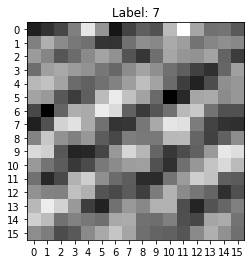

Input features: torch.Size([16, 16])
	tensor([[-1.8351e+00, -1.4840e+00, -1.0692e+00,  1.1173e-02,  2.0173e+00,
          4.4214e-01, -2.0250e+00, -1.1489e+00, -6.1356e-01, -8.5416e-01,
          1.1679e+00,  2.5220e+00,  7.8409e-01, -2.6112e-01, -1.9567e-01,
         -7.2808e-01],
        [ 2.6712e-02,  9.5666e-01,  2.5714e-01, -1.1131e-01, -2.7894e-01,
         -1.4273e+00, -1.4631e+00, -2.3086e-01,  3.0422e-01,  1.9526e-01,
          8.5145e-01,  6.1298e-01, -2.0938e-01,  1.5888e-01,  3.3639e-01,
          1.9480e-01],
        [ 5.5841e-01,  1.2744e-01, -7.8847e-01, -3.8050e-01,  2.2415e-01,
          7.1855e-01,  3.6820e-01, -8.2138e-01, -1.3975e+00, -2.9768e-01,
          7.8436e-01,  4.3849e-01,  3.7780e-01,  7.2650e-01, -5.2779e-01,
         -1.2758e+00],
        [-3.1651e-01,  6.3875e-01,  8.1279e-01,  5.6609e-01,  3.8547e-01,
         -1.4476e-01, -4.5122e-01,  2.7880e-01,  7.4213e-01,  3.2094e-01,
         -2.7227e-01, -6.1371e-01, -1.1920e+00, -1.5136e+00, -4.6419e-01,
     

In [6]:
train_loader = DataLoader(shmDS, batch_size=batch_size, shuffle=True) # split samples into mini-batches and reshuffle the data to reduce overfitting
test_loader = DataLoader(shmDS, batch_size=batch_size, shuffle=False)

train_features, train_labels = next(iter(train_loader))
# train_features = train_features.unsqueeze(dim=1)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
fig, axis = plt.subplots()
axis.imshow(img, cmap="gray")

axis.set(title=f"Label: {label}", xticks=range(16), yticks=range(16))
plt.show()
print(f"Input features: {img.shape}\n\t{img}")
print(f"Label: {label.shape}\n\t{label}")

# Build the neural network

## CNN Model

In [7]:
# Four-layer convolution
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## by HB
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(1, 4, kernel_size=4, padding=1),
        #     nn.BatchNorm2d(4),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2))
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(4, 8, kernel_size=4, padding=1),
        #     nn.BatchNorm2d(8),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2))
        # self.fc = nn.Linear(3*3*8, 9)
        
        ## by Chen
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32 * 1 * 1, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # print(x.shape)
        x = x.view(x.size(0), -1) 
        # print(x.shape)
        x = self.fc(x)
        return x

cnn = CNN()

## Loss and Optimizer

In [8]:
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# Train the model

In [9]:
for epoch in range(num_epochs):
    for i, (train_features, train_labels) in enumerate(train_loader):
        train_features = Variable(train_features)
        # images = images.unsqueeze(dim=1)
        train_features = train_features.float()
        train_labels = Variable(train_labels)
        # print(type(images), images)
        # print(type(labels), labels)
        # print("[ OK ] at this step") 

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(train_features)
        loss = loss_func(outputs, train_labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(shmDS) // batch_size, loss.item()))
    scheduler.step()

Epoch [1/5], Iter [100/771], Loss: 1.6231
Epoch [1/5], Iter [200/771], Loss: 1.2762
Epoch [1/5], Iter [300/771], Loss: 1.0707
Epoch [1/5], Iter [400/771], Loss: 0.8717
Epoch [1/5], Iter [500/771], Loss: 0.8612
Epoch [1/5], Iter [600/771], Loss: 0.8882
Epoch [1/5], Iter [700/771], Loss: 0.6024
Epoch [2/5], Iter [100/771], Loss: 0.6382
Epoch [2/5], Iter [200/771], Loss: 0.5865
Epoch [2/5], Iter [300/771], Loss: 0.6786
Epoch [2/5], Iter [400/771], Loss: 0.9338
Epoch [2/5], Iter [500/771], Loss: 0.5297
Epoch [2/5], Iter [600/771], Loss: 0.6635
Epoch [2/5], Iter [700/771], Loss: 0.7730
Epoch [3/5], Iter [100/771], Loss: 0.7348
Epoch [3/5], Iter [200/771], Loss: 0.7714
Epoch [3/5], Iter [300/771], Loss: 0.5944
Epoch [3/5], Iter [400/771], Loss: 0.9174
Epoch [3/5], Iter [500/771], Loss: 0.5424
Epoch [3/5], Iter [600/771], Loss: 1.0600
Epoch [3/5], Iter [700/771], Loss: 0.4468
Epoch [4/5], Iter [100/771], Loss: 0.6460
Epoch [4/5], Iter [200/771], Loss: 0.8578
Epoch [4/5], Iter [300/771], Loss:

# Test the model

In [10]:
cnn.eval()  # Change to test form, application scenarios such as: dropout
correct = 0
total = 0
for test_features, test_labels in test_loader:
    test_features = Variable(test_features)
    test_features = test_features.float()
    test_labels = Variable(test_labels)

    outputs = cnn(test_features)
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels.data).sum()
    
print(' Test Accuracy: %d %%' % (100 * correct / total))

# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

 Test Accuracy: 76 %


# Debugging ...

In [11]:
print("The last batch size should be", len(shmDS)%batch_size)
print("outputs has a shape of:", outputs.shape)
print("\tthe 1st item is:", outputs[1].shape, outputs[1])

print("predicted has a shape of:", predicted.shape)
print("\tthe 1st item is:", predicted[1].shape, predicted[1])

print("test_labels has a shape of:", test_labels.shape)
print("\tthe 1st item is:", test_labels[1].shape, test_labels[1])

The last batch size should be 0
outputs has a shape of: torch.Size([32, 9])
	the 1st item is: torch.Size([9]) tensor([ 1.8984,  3.5344, -1.3566, -1.9045, -0.1323, -0.0386, -0.6414, -0.4197,
        -2.0631], grad_fn=<SelectBackward0>)
predicted has a shape of: torch.Size([32])
	the 1st item is: torch.Size([]) tensor(1)
test_labels has a shape of: torch.Size([32])
	the 1st item is: torch.Size([]) tensor(8)
